# Set up

In [1]:
from google.colab import drive

drive.mount('/content/drive')
drive_path = 'drive/MyDrive'

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, BatchNormalization, ReLU
from keras.layers import MaxPooling2D, AveragePooling2D
# Image preprocessing
from keras.layers import Rescaling, Resizing
# Image augmentation
from keras.layers import RandomTranslation, RandomRotation, RandomZoom

# List of devices
tf.config.list_physical_devices()

# Plot model function
# keras.utils.plot_model(model, show_shapes = True)

# Model loading function
# model = keras.models.load_model('model.keras', compile = False)
# model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# model.summary()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Dataset

In [5]:
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelEncoder

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.concatenate((x_train, x_test))
x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2], 1))
y = np.concatenate((y_train, y_test))

print(x.shape)
print(y.shape)

11490434/11490434 [==============================] - 1s 0us/step
(70000, 28, 28, 1)
(70000,)


In [6]:
encoder = LabelEncoder()
encoder.fit(y_train)
print(encoder.inverse_transform([0]))
print(encoder.classes_)

[0]
[0 1 2 3 4 5 6 7 8 9]


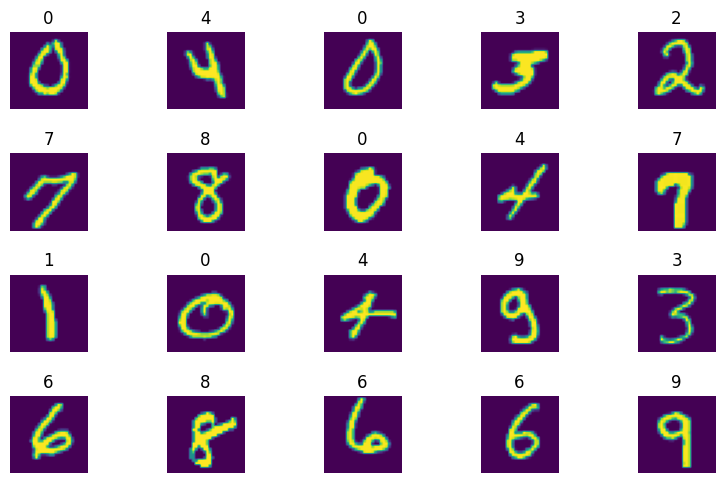

In [7]:
def showcase_image_dataset(x, y, encoder = None):
    plt.subplots(4, 5, figsize = (8, 5))
    plt.tight_layout()
    for i in range(0, 20):
        n = np.random.randint(0, x.shape[0])
        plt.subplot(4, 5, i + 1)
        plt.axis('off')
        if encoder == None:
            plt.gca().set_title(f'{y[n]}')
        else:
            plt.gca().set_title(f'{encoder.inverse_transform([y[n]])[0]} ({y[n]})')
        plt.imshow(x[n])
    plt.show()

showcase_image_dataset(x, y)

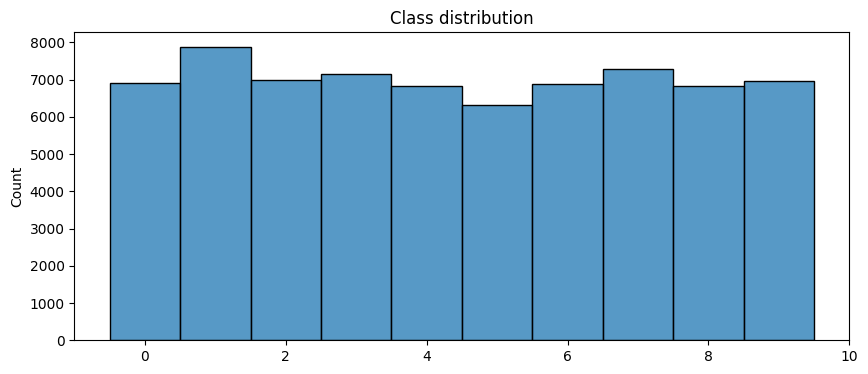

In [8]:
def show_class_distribution(y, encoder = None):
    plt.figure(figsize = (10, 4))
    plt.title('Class distribution')
    if encoder != None:
        sb.histplot(encoder.inverse_transform(y), discrete = True)
    else:
        sb.histplot(y, discrete = True)
    plt.show()

show_class_distribution(y)

# Augmentation

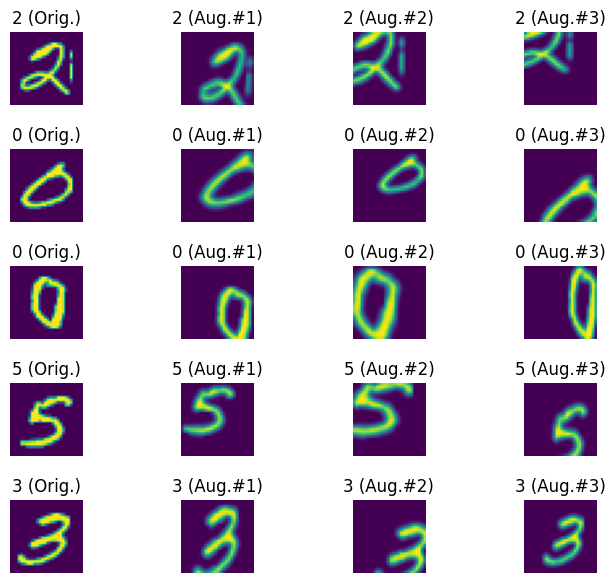

In [13]:
augmentation = Sequential([
    RandomRotation(0.03, fill_mode = 'constant'),
    RandomZoom(height_factor = 0.3, width_factor = 0.3, fill_mode = 'constant'),
    RandomTranslation(height_factor = 0.3, width_factor = 0.3, fill_mode = 'constant')
])

num_subplot = 0
plt.subplots(5, 4, figsize = (7, 6))
plt.tight_layout()
for i in range(0, 5):
    n = np.random.randint(0, x.shape[0])
    num_subplot += 1
    plt.subplot(5, 4, num_subplot)
    plt.axis('off')
    plt.gca().set_title(f'{y[n]} (Orig.)')
    plt.imshow(x[n])
    for j in range(0, 3):
        num_subplot += 1
        plt.subplot(5, 4, num_subplot)
        plt.axis('off')
        plt.gca().set_title(f'{y[n]} (Aug.#{j + 1})')
        image = augmentation(x[n], training = True).numpy().astype('uint8')
        plt.imshow(image)
plt.show()

# Dataset split

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

x_train_, x_test, y_train_, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42, shuffle = True)
x_train, x_val, y_train, y_val = train_test_split(x_train_, y_train_, test_size = 0.1, random_state = 42)

print(f'x train: {x_train.shape}')
print(f'y train: {y_train.shape}')
print()
print(f'x test: {x_test.shape}')
print(f'y test: {y_test.shape}')
print()
print(f'x validation: {x_val.shape}')
print(f'y validation: {y_val.shape}')

x train: (47250, 28, 28, 1)
y train: (47250,)

x test: (17500, 28, 28, 1)
y test: (17500,)

x validation: (5250, 28, 28, 1)
y validation: (5250,)


# CNN for classification

In [15]:
def show_confusion_matrix(labels_test, labels_predicted, labels = None):
    plt.figure(figsize = (10, 7))
    cm = confusion_matrix(labels_test, labels_predicted)
    if labels != None:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels = labels)
    else:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

def show_training_history(history, last_epoch = None):
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(history.history['loss'], color = 'b', label = 'Training loss')
    if 'val_loss' in history.history:
        ax[0].plot(history.history['val_loss'], color = 'r', label = 'Validation loss', axes = ax[0])
    if last_epoch is not None:
        ax[0].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
    legend = ax[0].legend(loc = 'best', shadow = True)
    ax[1].plot(history.history['accuracy'], color = 'b', label = 'Training accuracy')
    if 'val_accuracy' in history.history:
        ax[1].plot(history.history['val_accuracy'], color = 'r',label = 'Validation accuracy')
    if last_epoch is not None:
        ax[1].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
    legend = ax[1].legend(loc = 'best', shadow = True)
    plt.show()

In [16]:
img_width = x_train.shape[1]
img_height = x_train.shape[2]
channels = x_train.shape[3]
num_classes = len(encoder.classes_)

print(f'Width: {img_width}')
print(f'Height: {img_height}')
print(f'Channels: {channels}')
print(f'Number of classes: {num_classes}')

Width: 28
Height: 28
Channels: 1
Number of classes: 10


In [17]:
cnn = Sequential([
    # preprocessing
    #Rescaling(scale = 1.0/255.0, input_shape = (img_width, img_height, channels)),
    Rescaling(scale = 1.0/127.5, offset = -1, input_shape = (img_width, img_height, channels)),

    # augmentation
    RandomRotation(0.05),
    RandomZoom(height_factor = 0.3, width_factor = 0.3, fill_mode = 'constant'),
    RandomTranslation(height_factor = 0.3, width_factor = 0.3, fill_mode = 'constant'),

    # convolution
    Conv2D(32, (3, 3), input_shape = (img_width, img_height, channels)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2)),

    Conv2D(64, (3, 3)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2)),

    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.25),
    Dense(128, activation = 'relu'),
    Dropout(0.25),
    Dense(num_classes, activation = 'softmax')
])

cnn.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
input_shape = x_train.shape
cnn.build(input_shape = input_shape)
print(cnn.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 random_rotation_5 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 random_zoom_5 (RandomZoom)  (None, 28, 28, 1)         0         
                                                                 
 random_translation_5 (Rando  (None, 28, 28, 1)        0         
 mTranslation)                                                   
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)      

In [18]:
epochs = 200
batch_size = 32
cnn_history = cnn.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs)

loss, accuracy = cnn.evaluate(x_test, y_test)

print('---------')
print(f'Accuracy: {accuracy}, loss: {loss}')
print('---------')

Epoch 1/200
1477/1477 [==============================] - 33s 11ms/step - loss: 1.3540 - accuracy: 0.5217 - val_loss: 0.3491 - val_accuracy: 0.8935
Epoch 2/200
1477/1477 [==============================] - 14s 10ms/step - loss: 0.7084 - accuracy: 0.7668 - val_loss: 0.2876 - val_accuracy: 0.9063
Epoch 3/200
1477/1477 [==============================] - 12s 8ms/step - loss: 0.5449 - accuracy: 0.8248 - val_loss: 0.2521 - val_accuracy: 0.9265
Epoch 4/200
1477/1477 [==============================] - 12s 8ms/step - loss: 0.4607 - accuracy: 0.8533 - val_loss: 0.3128 - val_accuracy: 0.8924
Epoch 5/200
1477/1477 [==============================] - 12s 8ms/step - loss: 0.4169 - accuracy: 0.8666 - val_loss: 0.2054 - val_accuracy: 0.9387
Epoch 6/200
1477/1477 [==============================] - 12s 8ms/step - loss: 0.3798 - accuracy: 0.8790 - val_loss: 0.3634 - val_accuracy: 0.9055
Epoch 7/200
1477/1477 [==============================] - 12s 8ms/step - loss: 0.3518 - accuracy: 0.8893 - val_loss: 0.1311

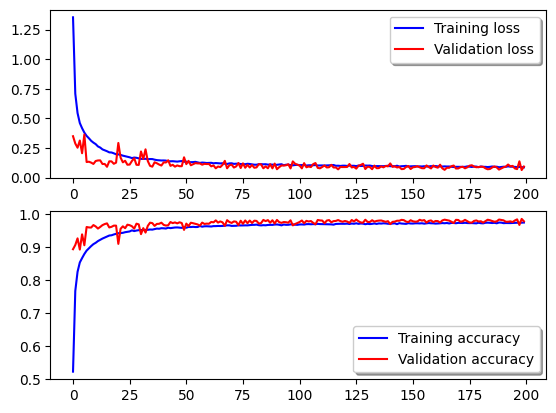

547/547 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1714
           1       1.00      0.97      0.98      1977
           2       0.94      0.99      0.96      1761
           3       0.98      0.99      0.99      1806
           4       0.99      0.97      0.98      1587
           5       0.99      0.97      0.98      1607
           6       0.99      0.98      0.98      1761
           7       0.97      0.98      0.97      1878
           8       0.97      0.98      0.97      1657
           9       0.99      0.96      0.98      1752

    accuracy                           0.98     17500
   macro avg       0.98      0.98      0.98     17500
weighted avg       0.98      0.98      0.98     17500



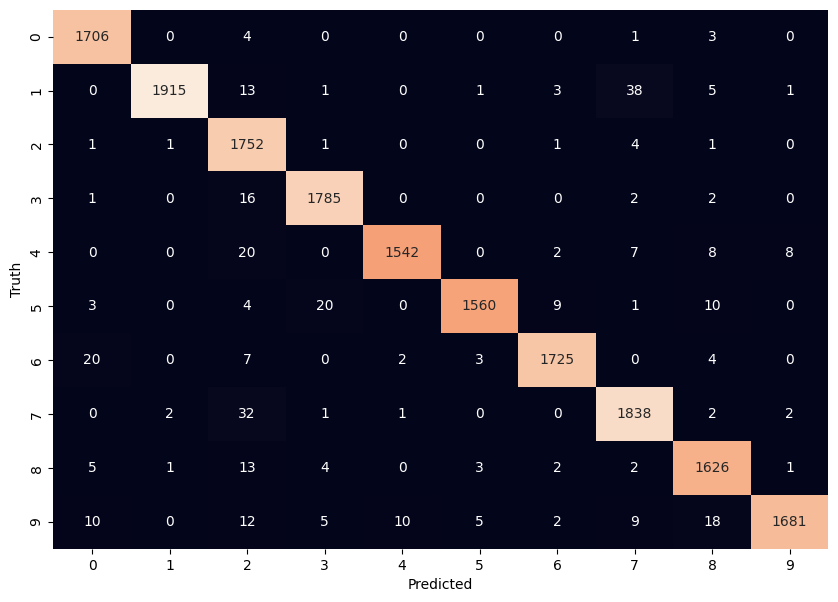

In [19]:
show_training_history(cnn_history)
y_predicted_from_cnn = np.argmax(cnn.predict(x_test), axis = 1)
print(classification_report(
    encoder.inverse_transform(y_test),
    encoder.inverse_transform(y_predicted_from_cnn)))
show_confusion_matrix(y_test, y_predicted_from_cnn, list(encoder.classes_))

In [20]:
cnn.save(f'{drive_path}/mnist_v2.keras')

# Visualization of predictions

## Test subset arrangement

In [22]:
import random

def make_test_subset(augmentation_model, seed = 42):
    random.seed(seed)
    test_images = []
    test_labels = []
    for i in range (0, 80):
        random_number = random.randint(0, x_test.shape[0] - 1)
        image = x_test[random_number]
        label = y_test[random_number]
        augmented_image = augmentation_model(image, training = True).numpy().astype('uint8')
        test_images.append(augmented_image)
        test_labels.append(label)
    return np.array(test_images), np.array(test_labels)

def show_digits_classification_result(images, true_labels, predicted_labels):
    plt.subplots(8, 10, figsize = (12, 8))
    plt.tight_layout()
    for i in range(0, 80):
        plt.subplot(8, 10, i + 1)
        plt.axis('off')
        predicted_label = predicted_labels[i]
        true_label = true_labels[i]
        image = images[i]
        title = f'{predicted_label}✔️' if true_label == predicted_label else f'{predicted_label}✘ [{true_label}]'
        plt.gca().set_title(title)
        plt.imshow(image)
    plt.show()

## Tests

### №1

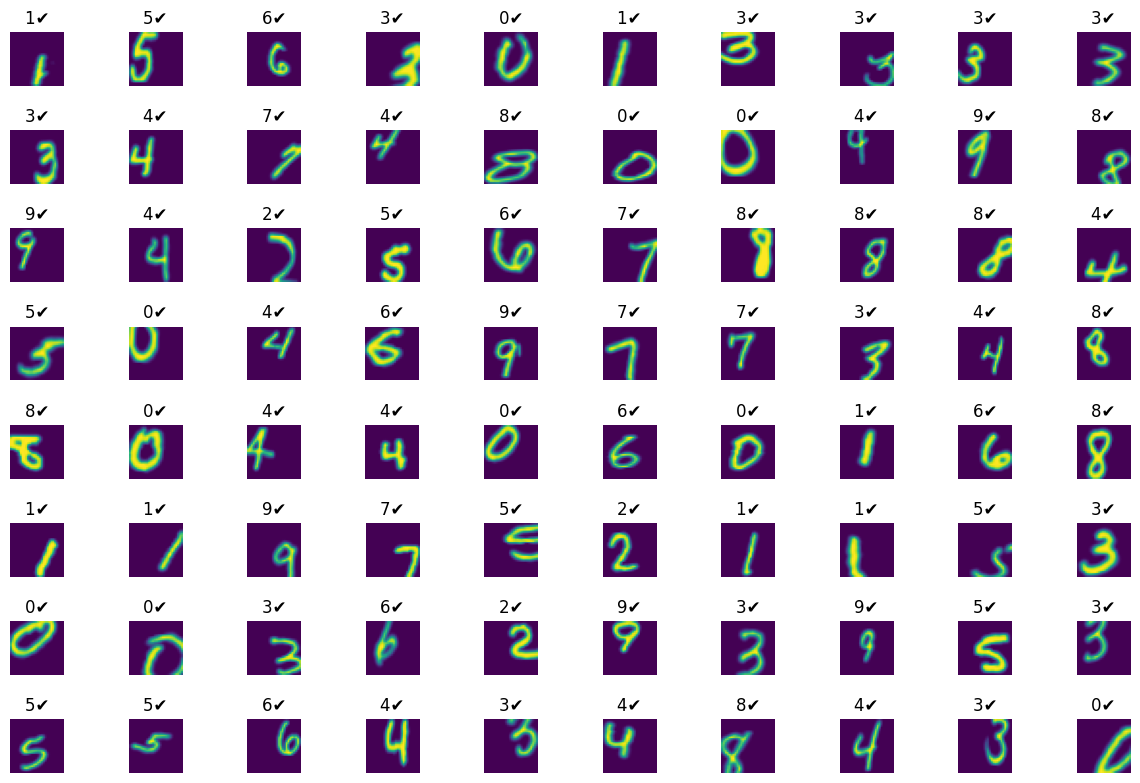

In [23]:
test_images, test_labels = make_test_subset(augmentation)
show_digits_classification_result(test_images, test_labels, test_labels)

3/3 [==============================] - 0s 40ms/step
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.88      1.00      0.93         7
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00        13
           4       1.00      0.92      0.96        12
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         7
           7       0.67      0.80      0.73         5
           8       1.00      1.00      1.00         9
           9       0.86      1.00      0.92         6

    accuracy                           0.95        80
   macro avg       0.94      0.93      0.93        80
weighted avg       0.96      0.95      0.95        80



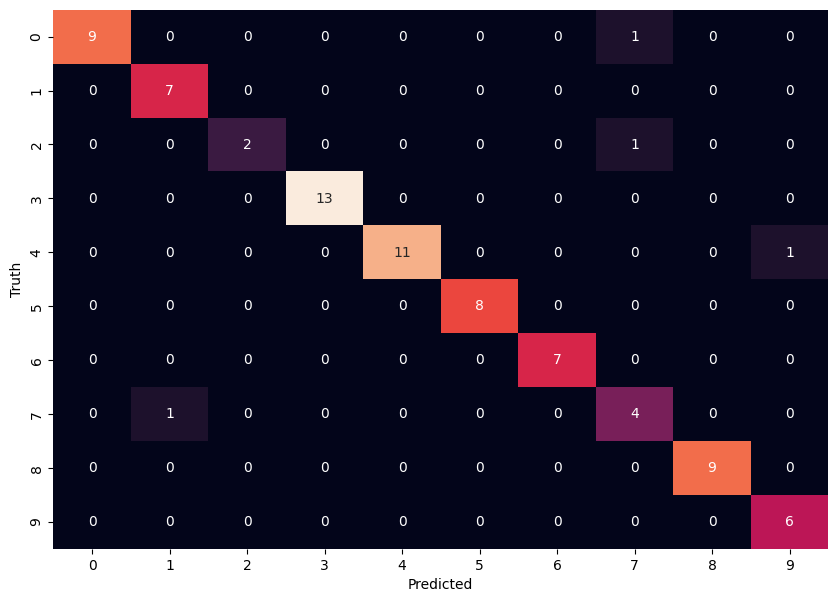

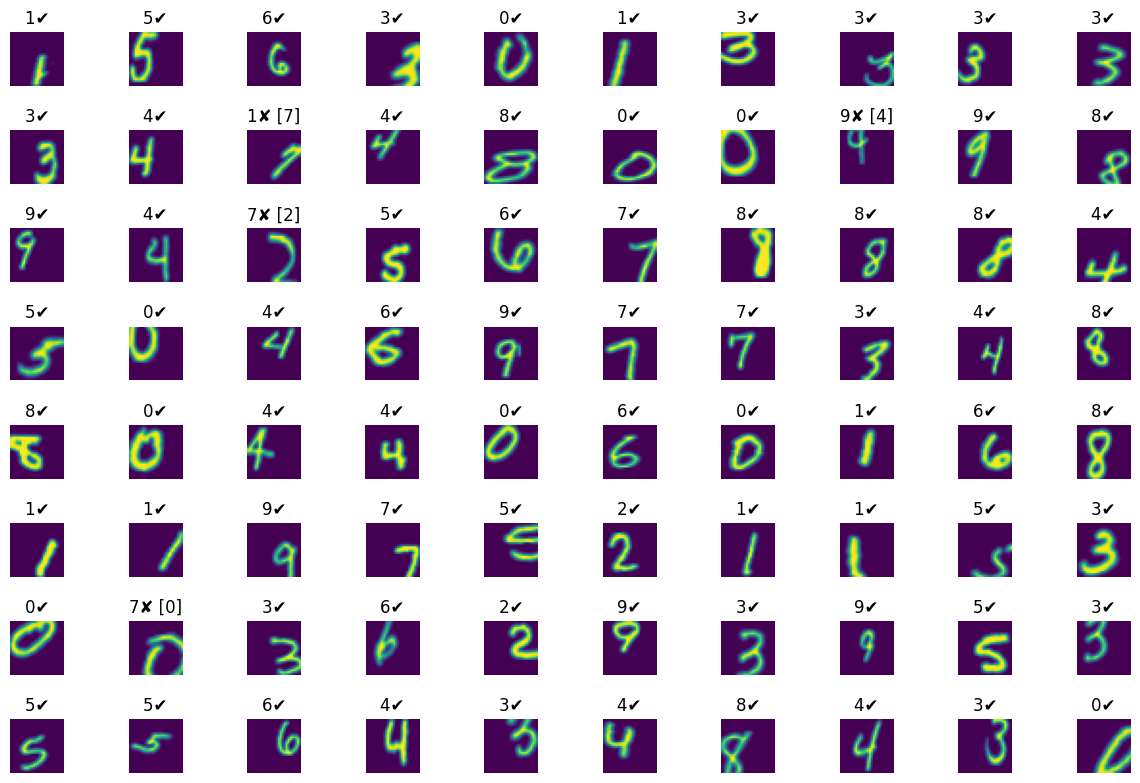

In [24]:
output = np.argmax(cnn.predict(test_images), axis = 1)
print(classification_report(test_labels, output))
show_confusion_matrix(test_labels, output)
show_digits_classification_result(test_images, test_labels, output)

### №2

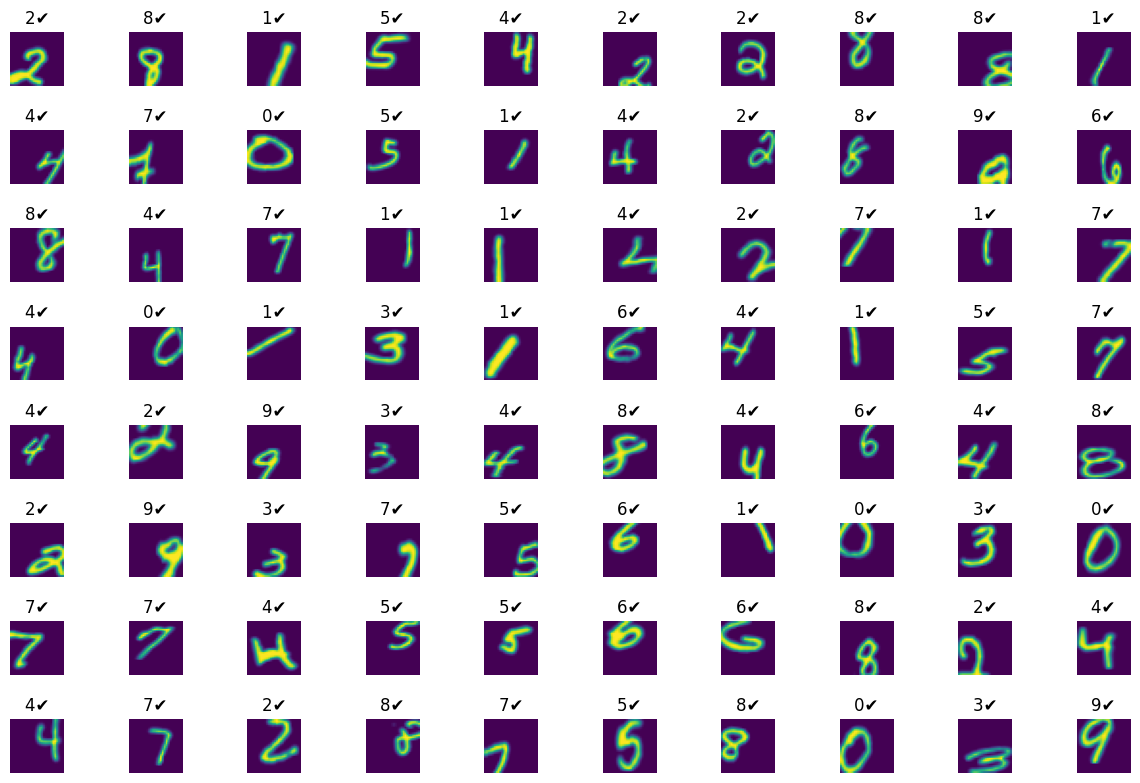

In [26]:
test_images, test_labels = make_test_subset(augmentation, seed = 1337)
show_digits_classification_result(test_images, test_labels, test_labels)

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.91      1.00      0.95        10
           2       0.78      0.78      0.78         9
           3       1.00      0.80      0.89         5
           4       1.00      0.93      0.96        14
           5       1.00      1.00      1.00         7
           6       0.75      1.00      0.86         6
           7       0.82      0.90      0.86        10
           8       1.00      0.90      0.95        10
           9       0.75      0.75      0.75         4

    accuracy                           0.90        80
   macro avg       0.90      0.89      0.89        80
weighted avg       0.91      0.90      0.90        80



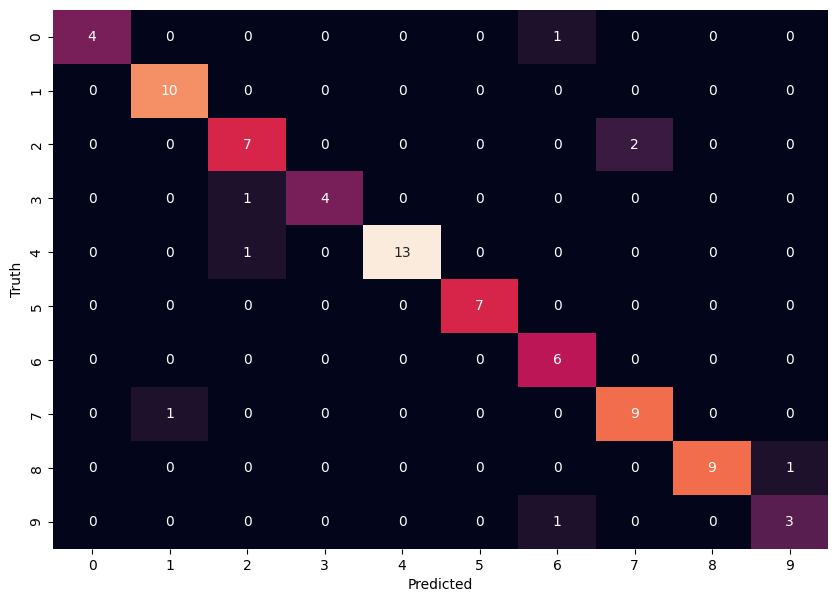

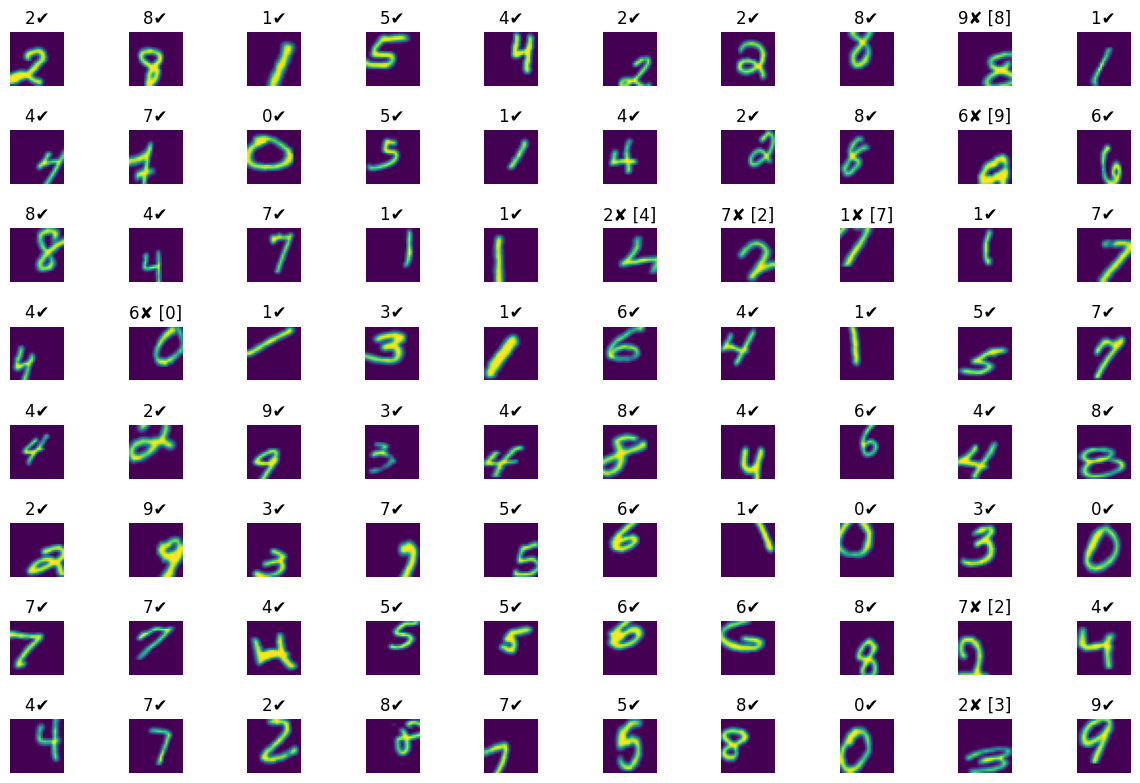

In [27]:
output = np.argmax(cnn.predict(test_images), axis = 1)
print(classification_report(test_labels, output))
show_confusion_matrix(test_labels, output)
show_digits_classification_result(test_images, test_labels, output)

### Wrong predictions showcase

In [28]:
prediction = np.argmax(cnn.predict(x_test), axis = 1)
errors = (prediction - y_test != 0)
predicted_labels = prediction[errors]
true_labels = y_test[errors]
images = x_test[errors]

547/547 [==============================] - 2s 3ms/step


In [34]:
predicted_labels.shape

(370,)

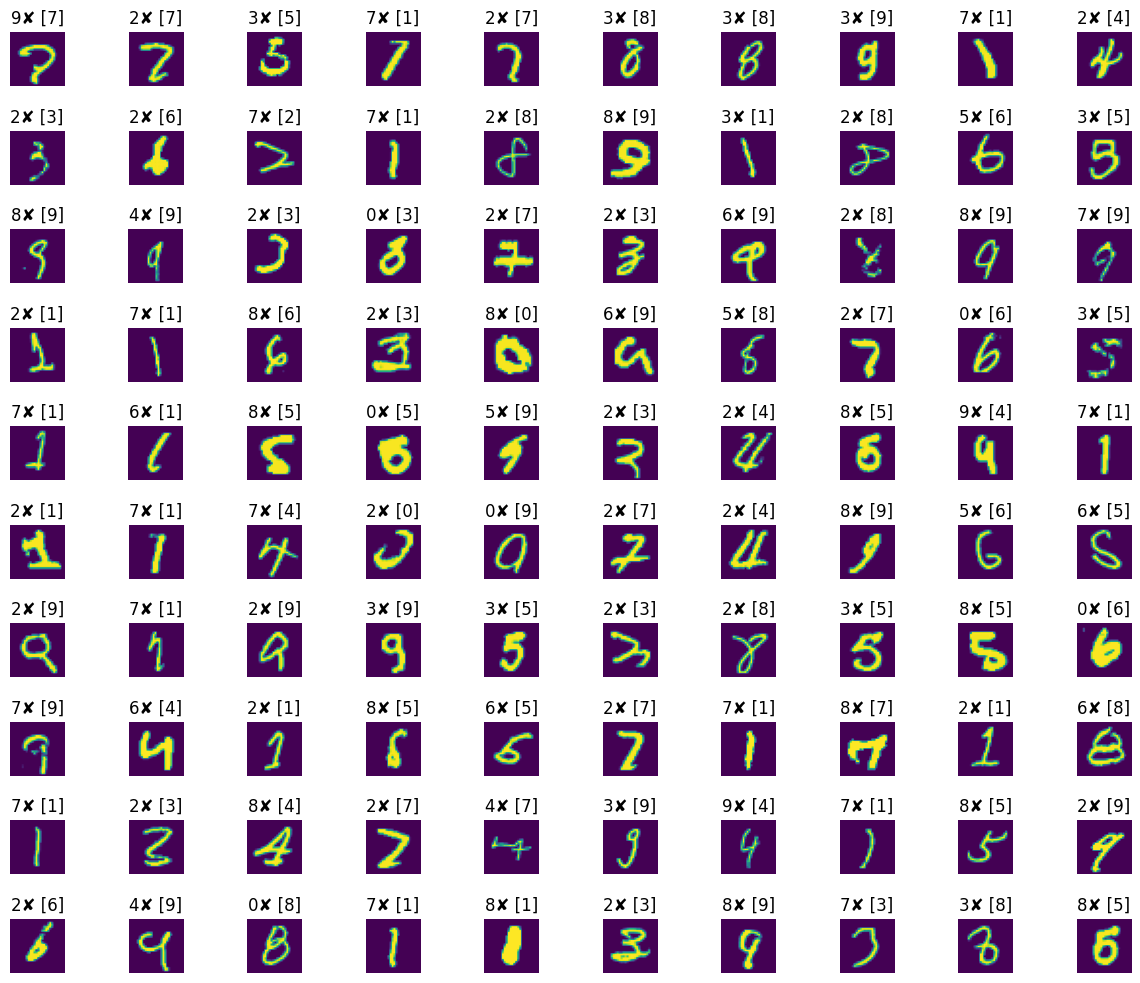

In [35]:
plt.subplots(10, 10, figsize = (12, 10))
plt.tight_layout()
for i in range(0, 100):
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    predicted_label = predicted_labels[i]
    true_label = true_labels[i]
    image = images[i]
    title = f'{predicted_label}✔️' if true_label == predicted_label else f'{predicted_label}✘ [{true_label}]'
    plt.gca().set_title(title)
    plt.imshow(image)
plt.show()